In [1]:
from pathlib import Path
from fastai import *
from fastai.vision.all import *
import torchvision.models as models
import os
import pandas as pd

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '7'
data_path = Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset')

In [3]:
#dls = ImageDataLoaders.from_folder(data_path,bs=64,item_tfms=Resize(128),batch_tfms=(aug_transforms(),Normalize.from_stats(*imagenet_stats)))
dls = ImageDataLoaders.from_folder(data_path,bs=64,item_tfms=Resize(128),batch_tfms=[*aug_transforms(),Normalize.from_stats(*imagenet_stats)])
dls.train_ds.items[:3]

[Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset/train/2/1740.png'),
 Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset/train/2/1989.png'),
 Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset/train/2/1597.png')]

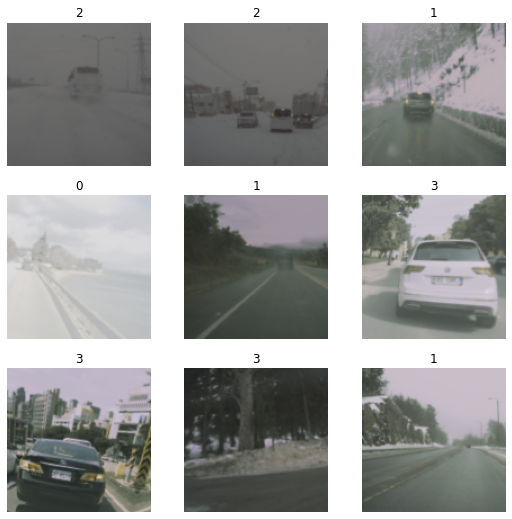

In [6]:
dls.show_batch()

In [4]:
densenet = models.densenet121(pretrained=True)

In [5]:
#learn = cnn_learner(dls, xresnet152(pretrained=True), metrics=[accuracy, error_rate], model_dir='./fastai_model_no_deep')
#learn = Learner(dls, xresnet152(pretrained=True), metrics=[accuracy, error_rate], model_dir='./fastai_model_no_deep')
learn = Learner(dls, densenet, metrics=[accuracy, error_rate], model_dir='./fastai_model_no_deep')

In [6]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

0.05754399373371566


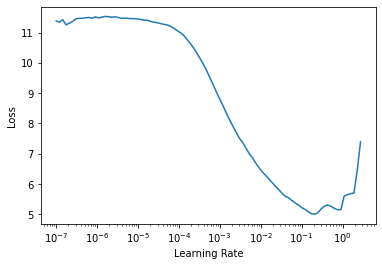

In [7]:
optimal_lr = find_appropriate_lr(learn)
print(optimal_lr)

In [ ]:
learn.fit_one_cycle(10, 0.0057, cbs=SaveModelCallback())
learn.export('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/densenet121.pkl')
#learn.save('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/stage-1-rn50')

Better model found at epoch 0 with valid_loss value: 0.535234808921814.
Better model found at epoch 2 with valid_loss value: 0.41566893458366394.
Better model found at epoch 3 with valid_loss value: 0.3176545202732086.


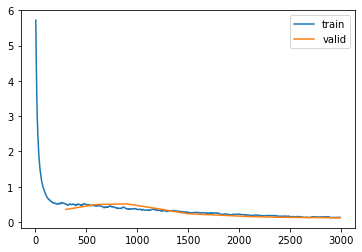

In [11]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [ ]:
interp.plot_top_losses(5, nrows=1)

## incremental training

In [14]:
learn_inf = load_learner('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xresnet152-10.pkl')
#dls = ImageDataLoaders.from_folder(data_path,bs=32,item_tfms=Resize(224),batch_tfms=[*aug_transforms(),Normalize.from_stats(*imagenet_stats)])
dls = ImageDataLoaders.from_folder(data_path,bs=32,item_tfms=[RandomResizedCrop(460, min_scale=0.75)],
                                   batch_tfms=[*aug_transforms(size=224, max_warp=0, max_rotate=0)])
learn_inf.dls = dls

In [15]:
learn_inf.fit_one_cycle(15, 0.005, cbs=SaveModelCallback())
learn_inf.export('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xresnet152-10.pkl')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.089868,0.127108,0.955604,0.044396,05:20
1,0.127153,0.797059,0.777143,0.222857,05:26
2,0.147019,0.352827,0.873626,0.126374,05:19
3,0.155032,0.461988,0.827473,0.172527,05:18
4,0.159863,0.212633,0.925714,0.074286,05:19
5,0.146218,1.057048,0.689890,0.310110,05:18
6,0.125864,0.163140,0.943516,0.056484,05:20
7,0.114117,0.168317,0.941099,0.058901,05:19
8,0.095871,0.209740,0.922418,0.077582,05:20
9,0.090124,0.270121,0.906813,0.093187,05:19


Better model found at epoch 0 with valid_loss value: 0.12710809707641602.


## inference

In [4]:
learn_inf = load_learner('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xresnet152-10.pkl',cpu=False)
#fnames = get_image_files('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/test_dataset')
test_csv = '/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/inference.csv'
test_list = pd.read_csv(test_csv)
path_list = []

for i in range(len(test_list['img_path'])):
    img_path = '/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/'+test_list['img_path'][i]
    path_list.append(Path(img_path))

probs,targs = learn_inf.get_preds(dl=learn_inf.dls.test_dl(path_list))

In [5]:
dry = []
wet = []
snowy = []
na = []

result = probs.cuda().data.cpu().numpy()
for i in range(len(result)):
    #print(result)
    dry.append(result[i][0])
    wet.append(result[i][1])
    snowy.append(result[i][2])
    na.append(result[i][3])

cont_list = {'dry':dry, 'wet':wet, 'snowy':snowy, 'na':na}
df = pd.DataFrame(cont_list, columns=['dry','wet','snowy','na'])
df.to_csv('result.csv')

In [3]:
learn_inf = load_learner('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xresnet152-10.pkl',cpu=False)
#fnames = get_image_files('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/test_dataset')
test_csv = '/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/inference.csv'
test_list = pd.read_csv(test_csv)
path_list = []

for i in range(len(test_list['img_path'])):
    img_path = '/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/'+test_list['img_path'][i]
    path_list.append(Path(img_path))
preds,y = learn_inf.tta(dl=learn_inf.dls.test_dl(path_list))

epoch,train_loss,valid_loss,accuracy,error_rate,time


AttributeError: 'NBProgressBar' object has no attribute 'wait_for'